## Preambule

In [1]:
# Plotting0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from plotly.colors import n_colors

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10216\2835491201.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
countries_iso = np.load("K:/ECEMF/T5.2/all_countries.npy", allow_pickle=True)

## Input

In [3]:
rules_b = ["GF", "PC", "PCC", "AP", "GDR", "ECPC"]

## Read data

In [4]:
xr_dataread_ipcc = xr.open_dataset("K:/data/DataUpdate_ongoing/IPCC/xr_dataread.nc")
xr_dataread = xr.open_dataset("K:/data/DataUpdate_ongoing/xr_dataread.nc")

In [5]:
df_ar6_raw = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [6]:
df_ar6 = df_ar6_raw[
    df_ar6_raw.Variable.isin(
        [
            "Emissions|Kyoto Gases",
            "Emissions|CO2",
            "Emissions|CH4",
            "Emissions|N2O",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
        ]
    )
]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel(
    "X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",
    sheet_name="meta_Ch3vetted_withclimate",
)
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i] + "|" + scens[i] for i in range(len(scens))])
df_ar6_meta["ModelScenario"] = modscens_meta
df_ar6_meta = df_ar6_meta[["ModelScenario", "Category", "Policy_category"]]

df_ar6_meta_c1 = df_ar6_meta[df_ar6_meta.Category.isin(["C1"])]
df_ar6_meta_c1 = df_ar6_meta_c1.reset_index(drop=True)
ms_c1 = np.array(df_ar6_meta_c1.ModelScenario)

df_ar6_meta_c2 = df_ar6_meta[df_ar6_meta.Category.isin(["C2"])]
df_ar6_meta_c2 = df_ar6_meta_c2.reset_index(drop=True)
ms_c2 = np.array(df_ar6_meta_c2.ModelScenario)

df_ar6_meta_c3 = df_ar6_meta[df_ar6_meta.Category.isin(["C3"])]
df_ar6_meta_c3 = df_ar6_meta_c3.reset_index(drop=True)
ms_c3 = np.array(df_ar6_meta_c3.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i] + "|" + scens[i] for i in range(len(scens))])
df_ar6["ModelScenario"] = modscens
df_ar6 = df_ar6.drop(["Model", "Scenario", "Unit", "Region"], axis=1)

In [7]:
dummy = df_ar6.melt(id_vars=["Variable", "ModelScenario"], var_name="Time", value_name="Value")
dummy["Time"] = np.array(dummy["Time"].astype(int))
dummy = dummy.set_index(["Variable", "ModelScenario", "Time"])
xr_scen = xr.Dataset.from_dataframe(dummy)
xr_scen = xr_scen.reindex(Time=np.arange(1990, 2101))
xr_scen = xr_scen.interpolate_na(dim="Time", method="linear")

In [8]:
def ms_temp(T):
    peaktemp = xr_scen.sel(
        Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"
    ).Value.max(dim="Time")
    return xr_scen.ModelScenario[np.where((peaktemp < T + 0.05) & (peaktemp > T - 0.05))[0]]


def ms_temp_mx(T):
    peaktemp = xr_scen.sel(
        Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"
    ).Value.max(dim="Time")
    return xr_scen.ModelScenario[np.where(peaktemp < T + 0.05)[0]]

## Plots

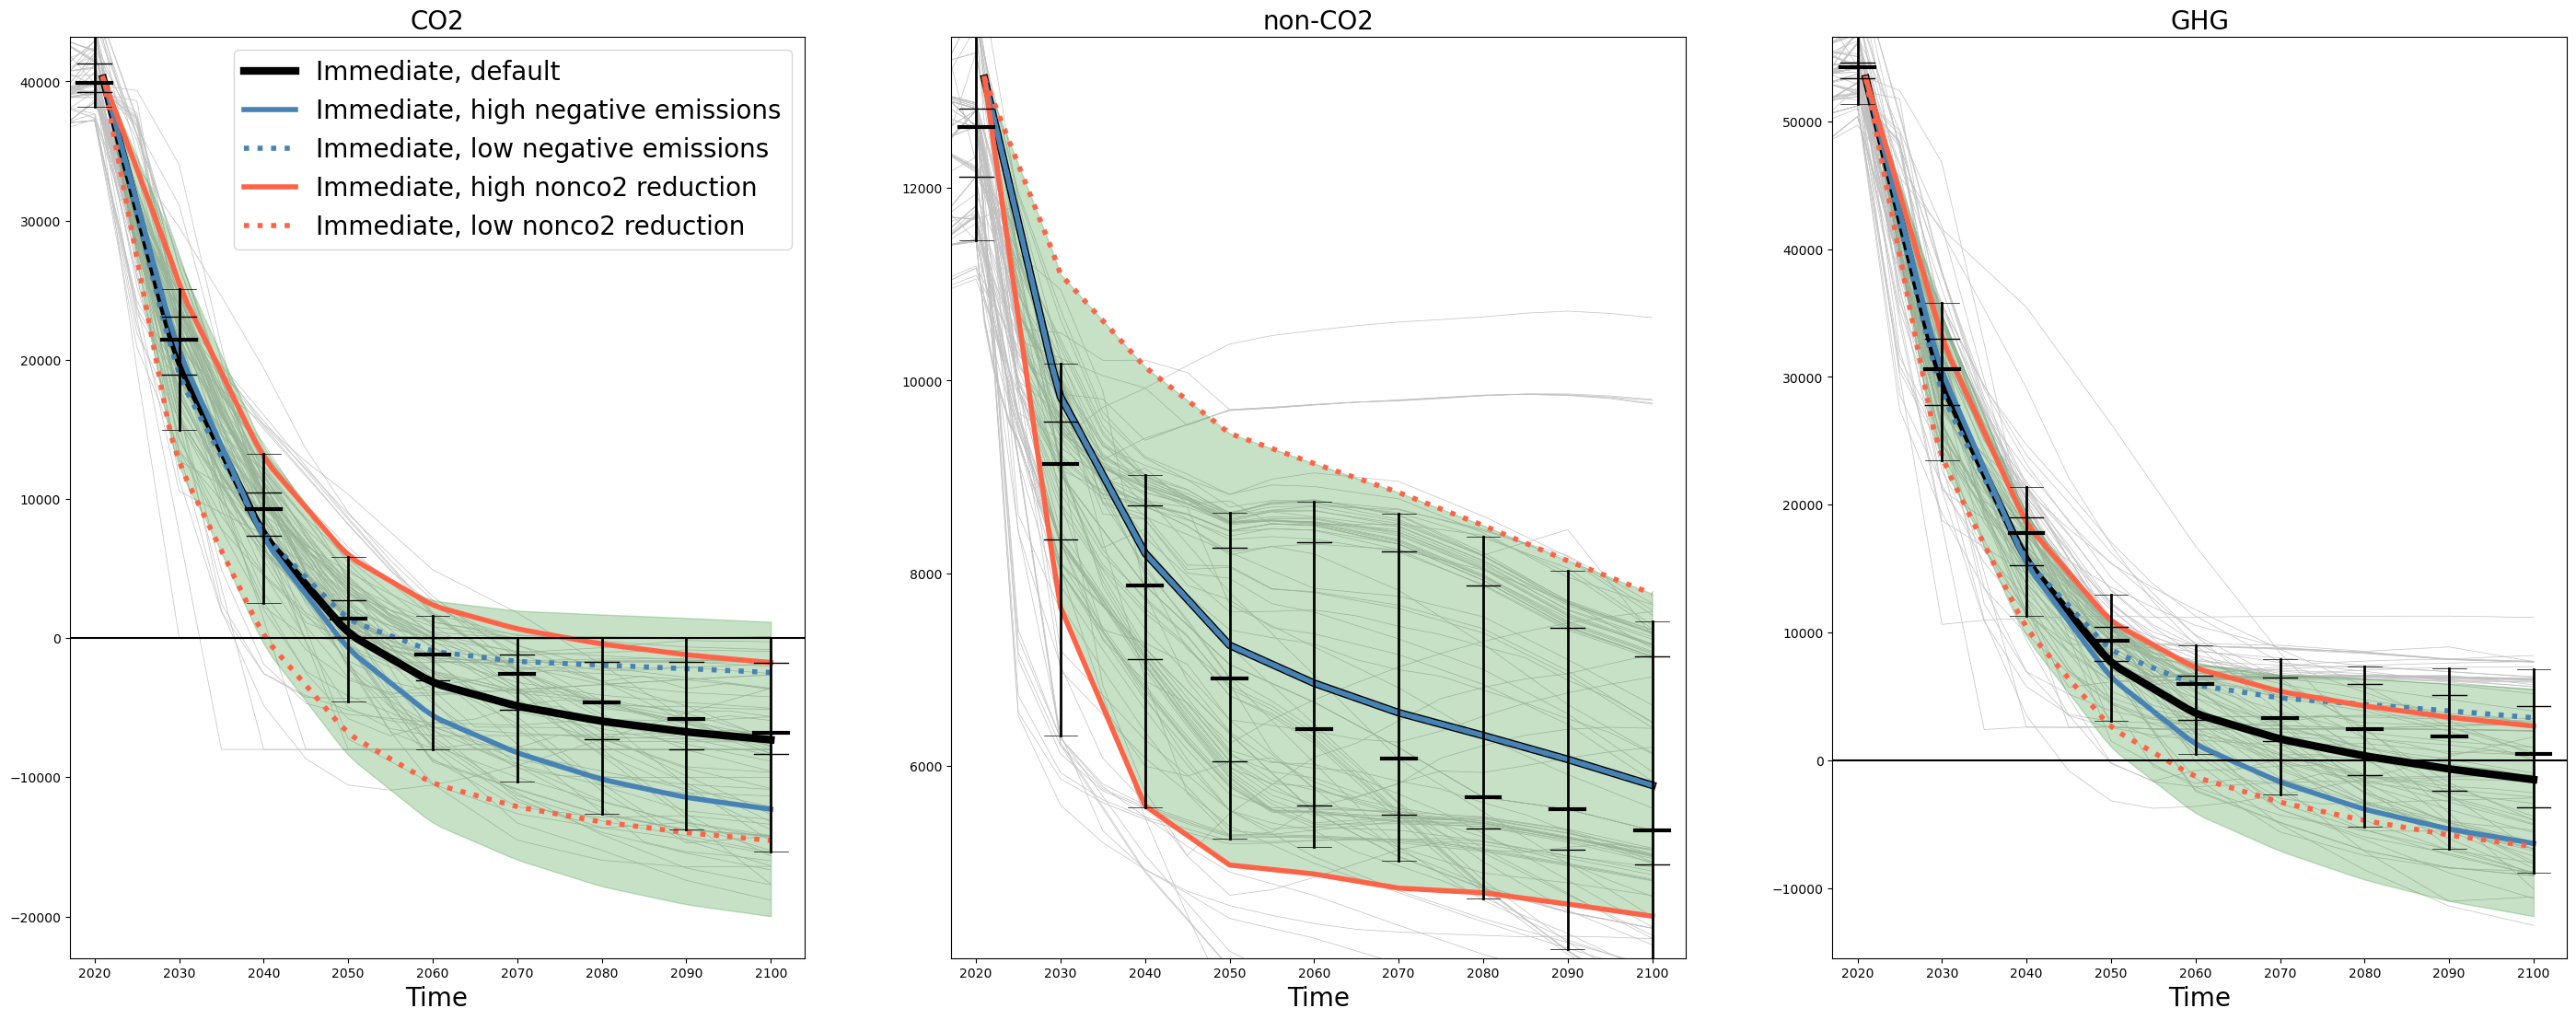

In [9]:
temp = 1.6

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35, 13), sharex=True, facecolor="w")

data = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate", NegEmis=0.5, NonCO2red=0.5)
ax1.plot(xr_dataread.Time, data.CO2_globe, lw=6, label="Immediate, default", c="k")
ax2.plot(xr_dataread.Time, data.NonCO2_globe, lw=6, c="k")
ax3.plot(xr_dataread.Time, data.GHG_globe, lw=6, c="k")

data = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate", NegEmis=0.8, NonCO2red=0.5)
ax1.plot(
    xr_dataread.Time,
    data.CO2_globe,
    lw=4,
    label="Immediate, high negative emissions",
    c="steelblue",
)
ax2.plot(xr_dataread.Time, data.NonCO2_globe, lw=4, c="steelblue")
ax3.plot(xr_dataread.Time, data.GHG_globe, lw=4, c="steelblue")

data = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate", NegEmis=0.2, NonCO2red=0.5)
ax1.plot(
    xr_dataread.Time,
    data.CO2_globe,
    ":",
    lw=4,
    label="Immediate, low negative emissions",
    c="steelblue",
)
ax2.plot(xr_dataread.Time, data.NonCO2_globe, ":", lw=4, c="steelblue")
ax3.plot(xr_dataread.Time, data.GHG_globe, ":", lw=4, c="steelblue")

data = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate", NegEmis=0.5, NonCO2red=0.9)
ax1.plot(
    xr_dataread.Time, data.CO2_globe, lw=4, label="Immediate, high nonco2 reduction", c="tomato"
)
ax2.plot(xr_dataread.Time, data.NonCO2_globe, lw=4, c="tomato")
ax3.plot(xr_dataread.Time, data.GHG_globe, lw=4, c="tomato")

data = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate", NegEmis=0.5, NonCO2red=0.1)
ax1.plot(
    xr_dataread.Time, data.CO2_globe, ":", lw=4, label="Immediate, low nonco2 reduction", c="tomato"
)
ax2.plot(xr_dataread.Time, data.NonCO2_globe, ":", lw=4, c="tomato")
ax3.plot(xr_dataread.Time, data.GHG_globe, ":", lw=4, c="tomato")

data1 = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate").max(
    dim=["NegEmis", "NonCO2red"]
)
data2 = xr_dataread.sel(Temperature=temp, Risk=0.5, Timing="Immediate").min(
    dim=["NegEmis", "NonCO2red"]
)
ax1.fill_between(
    xr_dataread.Time,
    data1.CO2_globe,
    data2.CO2_globe,
    where=data1.CO2_globe >= data2.CO2_globe,
    color="forestgreen",
    alpha=0.25,
)
ax2.fill_between(
    xr_dataread.Time,
    data1.NonCO2_globe,
    data2.NonCO2_globe,
    where=data1.NonCO2_globe >= data2.NonCO2_globe,
    color="forestgreen",
    alpha=0.25,
)
ax3.fill_between(
    xr_dataread.Time,
    data1.GHG_globe,
    data2.GHG_globe,
    where=data1.GHG_globe >= data2.GHG_globe,
    color="forestgreen",
    alpha=0.25,
)

ax1.legend(fontsize=20)
for ax_i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlabel("Time", fontsize=20)
    ax.set_title(["CO2", "non-CO2", "GHG"][ax_i], fontsize=20)
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot([-1e3, 1e5], [0, 0], c="k")

# AR6 part
mslist = ms_c1  # ms_temp(temp)
for ms_i, ms in enumerate(mslist):
    dat = xr_scen.sel(Variable="Emissions|CO2", ModelScenario=ms).Value
    offset = float(dat.sel(Time=2021) - xr_dataread.CO2_globe.sel(Time=2021).mean())
    ax1.plot(xr_scen.Time, dat, c="silver", lw=0.5, zorder=-1)
    dat_new = dat - offset
    # ax1.plot(xr_scen.Time, dat_new, c='silver', lw=0.5, zorder=-1)

    dat = (
        xr_scen.sel(Variable="Emissions|CH4", ModelScenario=ms).Value * 25
        + xr_scen.sel(Variable="Emissions|N2O", ModelScenario=ms).Value * 298 / 1e3
    )
    offset = float(dat.sel(Time=2021) - xr_dataread.NonCO2_globe.sel(Time=2021).mean())
    ax2.plot(xr_scen.Time, dat, c="silver", lw=0.5, zorder=-1)
    dat_new = dat - offset
    # ax2.plot(xr_scen.Time, dat_new, c='silver', lw=0.5, zorder=-1)

    dat = xr_scen.sel(Variable="Emissions|Kyoto Gases", ModelScenario=ms).Value
    offset = float(dat.sel(Time=2021) - xr_dataread.GHG_globe.sel(Time=2021).mean())
    ax3.plot(xr_scen.Time, dat, c="silver", lw=0.5, zorder=-1)
    dat_new = dat - offset
    # ax3.plot(xr_scen.Time, dat_new, c='silver', lw=0.5, zorder=-1)
dx = 2
for time_i, time in enumerate([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]):
    for var_i, var in enumerate(["Emissions|CO2", "NonCO2", "Emissions|Kyoto Gases"]):
        ax = [ax1, ax2, ax3][var_i]
        if var != "NonCO2":
            val = xr_scen.sel(Variable=var, ModelScenario=mslist).Value
        else:
            val = (
                xr_scen.sel(Variable="Emissions|CH4", ModelScenario=mslist).Value * 25
                + xr_scen.sel(Variable="Emissions|N2O", ModelScenario=mslist).Value * 298 / 1e3
            )
        for perc_i, perc in enumerate([0.1, 0.33, 0.5, 0.67, 0.9]):
            ax.plot(
                [time - dx, time + dx],
                [
                    val.sel(Time=time).quantile(perc, dim="ModelScenario"),
                    val.sel(Time=time).quantile(perc, dim="ModelScenario"),
                ],
                "k",
                lw=[0.5, 1, 3, 1, 0.5][perc_i],
            )
        ax.plot(
            [time, time],
            [
                val.sel(Time=time).quantile(0.1, dim="ModelScenario"),
                val.sel(Time=time).quantile(0.9, dim="ModelScenario"),
            ],
            "k",
            lw=2,
        )
# for time_i, time in enumerate([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]):
#     for var_i, var in enumerate(['Emissions|CO2', 'NonCO2', 'Emissions|Kyoto Gases']):
#         ax = [ax1, ax2, ax3][var_i]
#         if var != 'NonCO2': val = xr_scen.sel(Variable=var, ModelScenario=ms_temp(temp)).Value
#         else: val = xr_scen.sel(Variable='Emissions|CH4', ModelScenario=ms_temp(temp)).Value*25 + xr_scen.sel(Variable='Emissions|N2O', ModelScenario=ms_temp(temp)).Value*298/1e3
#         for perc_i, perc in enumerate([0.1, 0.33, 0.5, 0.67, 0.9]):
#             ax.plot([time-dx, time+dx], [val.sel(Time=time).quantile(perc, dim='ModelScenario'), val.sel(Time=time).quantile(perc, dim='ModelScenario')], 'purple', lw=[0.5, 1, 3, 1, 0.5][perc_i])
#         ax.plot([time, time], [val.sel(Time=time).quantile(0.1, dim='ModelScenario'), val.sel(Time=time).quantile(0.9, dim='ModelScenario')], 'purple', lw=2)
# plt.savefig("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Presentations/GlobalPathways.png", dpi=250)

Ideetje Detlef

In [10]:
emis_2020 = float(xr_dataread.GHG_hist.sel(Time=2020, Region="EARTH"))
xr_red = (xr_dataread.GHG_globe.sel(Risk=0.5) - emis_2020) / emis_2020

In [11]:
emis_2020_ar6 = xr_scen.sel(Variable="Emissions|Kyoto Gases", Time=2020).Value
reds_2030 = (
    xr_scen.sel(Variable="Emissions|Kyoto Gases", Time=2030).Value - emis_2020_ar6
) / emis_2020_ar6
reds_2040 = (
    xr_scen.sel(Variable="Emissions|Kyoto Gases", Time=2040).Value - emis_2020_ar6
) / emis_2020_ar6
peaktemps = (
    xr_scen.sel(
        Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"
    )
    .max(dim="Time")
    .Value
)
# netzeroyears =

In [12]:
ar6_years = []
ar6_cumco2 = []
for ms in xr_scen.ModelScenario:
    wh = np.where(xr_scen.sel(Variable="Emissions|CO2", ModelScenario=ms).Value <= 0)[0]
    if len(wh) > 0:
        year = float(xr_scen.Time[wh[0]])
        ar6_years.append(year)
        ar6_cumco2.append(
            float(
                xr_scen.sel(Variable="Emissions|CO2", ModelScenario=ms, Time=np.arange(2021, year))
                .sum(dim="Time")
                .Value
            )
        )
    else:
        ar6_years.append(np.nan)
        ar6_cumco2.append(np.nan)

In [13]:
times = np.array(xr_dataread.Time)


def netzeroyears(timing, neg, nonco2):
    years = []
    cumco2s = []
    for t_i, t in enumerate(np.array(xr_dataread.Temperature)):
        wh = np.where(
            xr_dataread.CO2_globe.sel(
                Risk=0.5, Timing=timing, NegEmis=neg, NonCO2red=nonco2, Temperature=t
            )
            <= 0
        )[0]
        if len(wh) > 0:
            year = times[wh[0]]
            cumco2 = float(
                xr_dataread.CO2_globe.sel(
                    Risk=0.5,
                    Timing=timing,
                    NegEmis=neg,
                    NonCO2red=nonco2,
                    Temperature=t,
                    Time=np.arange(2021, year),
                ).sum(dim="Time")
            )
        else:
            year = np.nan
            cumco2 = np.nan
        years.append(year)
        cumco2s.append(cumco2)
    return years, cumco2s

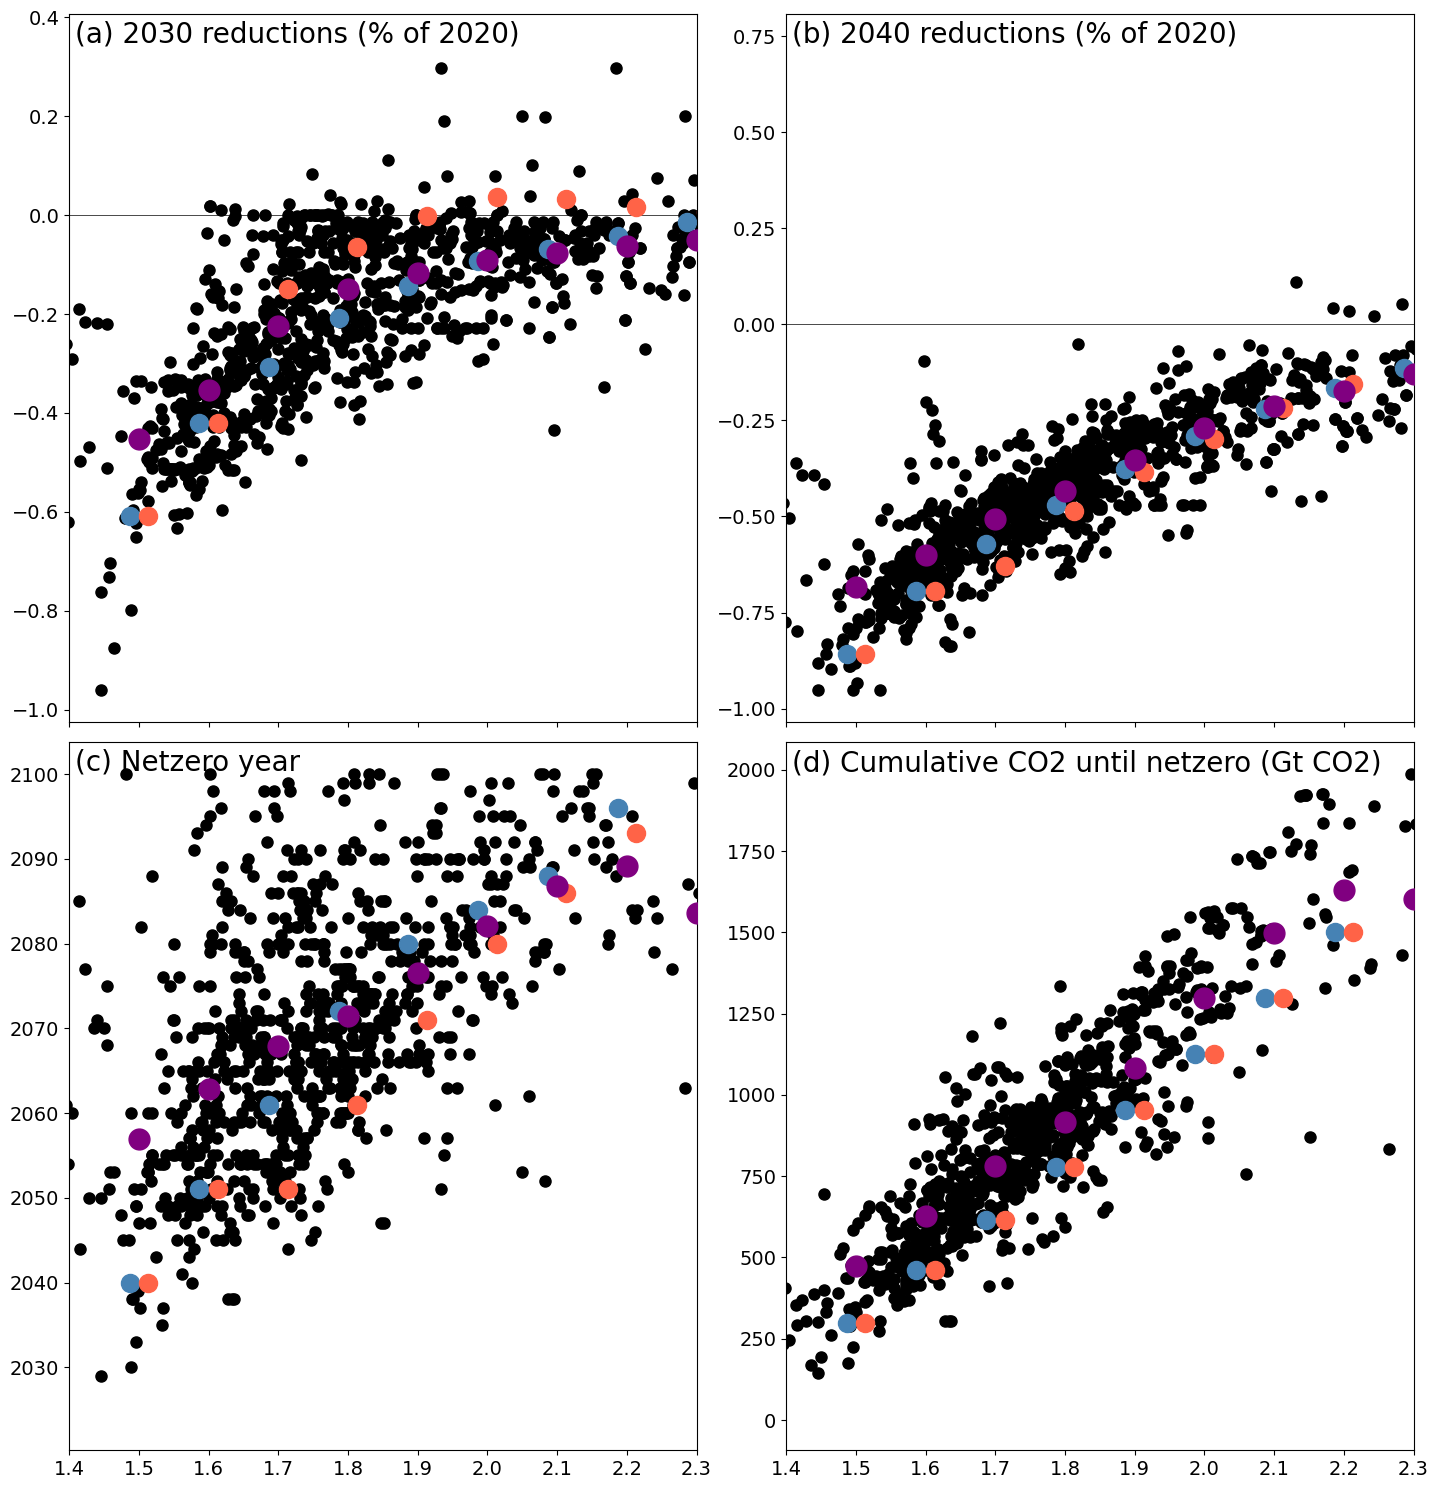

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15), sharex=True, facecolor="white")
for timing_i, timing in enumerate(xr_red.Timing):
    for nonco2_i, nonco2 in enumerate([0.5]):  # xr_red.NonCO2red):
        for neg_i, neg in enumerate([0.5]):  # xr_red.NegEmis):
            ax1.plot(
                xr_red.Temperature - [1, -1][timing_i] / 75,
                xr_red.sel(Time=2030, Timing=timing, NegEmis=neg, NonCO2red=nonco2),
                "o",
                c=["steelblue", "tomato"][timing_i],
                ms=13,
            )
            ax2.plot(
                xr_red.Temperature - [1, -1][timing_i] / 75,
                xr_red.sel(Time=2040, Timing=timing, NegEmis=neg, NonCO2red=nonco2),
                "o",
                c=["steelblue", "tomato"][timing_i],
                ms=13,
            )
            years, cumco2s = netzeroyears(timing, neg, nonco2)
            ax3.plot(
                xr_red.Temperature - [1, -1][timing_i] / 75,
                years,
                "o",
                c=["steelblue", "tomato"][timing_i],
                ms=13,
            )
            ax4.plot(
                xr_red.Temperature - [1, -1][timing_i] / 75,
                np.array(cumco2s) / 1e3,
                "o",
                c=["steelblue", "tomato"][timing_i],
                ms=13,
            )

ax1.plot(peaktemps, reds_2030, "o", c="k", zorder=-1, ms=8)
ax2.plot(peaktemps, reds_2040, "o", c="k", zorder=-1, ms=8)
ax3.plot(peaktemps, ar6_years, "o", c="k", zorder=-1, ms=8)
ax4.plot(peaktemps, np.array(ar6_cumco2) / 1e3, "o", c="k", zorder=-1, ms=8)

for t in np.array(xr_dataread.Temperature):
    wh = np.where(np.abs(peaktemps - t) < 0.1)[0]
    ax1.plot([t], [np.mean(reds_2030[wh])], "o", c="purple", zorder=1e9, ms=15)
    ax2.plot([t], [np.mean(reds_2040[wh])], "o", c="purple", zorder=1e9, ms=15)
    ax3.plot([t], [np.nanmean(np.array(ar6_years)[wh])], "o", c="purple", zorder=1e9, ms=15)
    ax4.plot([t], [np.nanmean(np.array(ar6_cumco2)[wh] / 1e3)], "o", c="purple", zorder=1e9, ms=15)

for ax_i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(
        0.01,
        0.99,
        [
            "(a) 2030 reductions (% of 2020)",
            "(b) 2040 reductions (% of 2020)",
            "(c) Netzero year",
            "(d) Cumulative CO2 until netzero (Gt CO2)",
        ][ax_i],
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=20,
    )
    ax.set_xlim([1.4, 2.3])
    ax.set_ylim(ax.get_ylim())
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.tick_params(axis="both", which="minor", labelsize=14)

ax1.plot([-1e3, 1e3], [0, 0], c="k", lw=0.5, zorder=-1)
ax2.plot([-1e3, 1e3], [0, 0], c="k", lw=0.5, zorder=-1)
fig.tight_layout()
# plt.savefig("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Presentations/GlobalPathways_test.png", dpi=250)

In [15]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10), sharex=True)
# for nonco2_i, nonco2 in enumerate(xr_dataread.NonCO2):
#     col = plt.cm.inferno(nonco2_i/len(xr_dataread.NonCO2))
#     ax1.plot(xr_dataread.Time, xr_dataread.CO2_globe.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2=nonco2), label='Leftover fraction nonco2 emissions: '+str(float(nonco2)), lw=3, c=col)
#     ax2.plot(xr_dataread.Time, xr_dataread.NonCO2_globe.sel(NonCO2=nonco2), label='Leftover fraction nonco2 emissions: '+str(float(nonco2)), lw=3, c=col)
#     ax3.plot(xr_dataread.Time, xr_dataread.GHG_globe.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2=nonco2), label='Leftover fraction nonco2 emissions: '+str(float(nonco2)), lw=3, c=col)

# ax1.legend()
# for ax_i, ax in enumerate([ax1, ax2, ax3]):
#     ax.set_xlabel("Time", fontsize=20)
#     ax.set_title(["CO2", "non-CO2", "GHG"][ax_i], fontsize=20)
#     ax.set_xlim(ax.get_xlim())
#     ax.set_ylim(ax.get_ylim())
#     ax.plot([-1e3, 1e5], [0, 0], c='k')

# mslist = ms_temp(1.5)
# for ms_i, ms in enumerate(mslist):
#     ax1.plot(xr_scen.Time, xr_scen.sel(Variable='Emissions|CO2', ModelScenario=ms).Value, c='silver', lw=0.5, zorder=-1)
#     ax1.plot(xr_scen.Time, xr_scen.sel(Variable='Emissions|CH4', ModelScenario=ms).Value + xr_scen.sel(Variable='Emissions|N2O', ModelScenario=ms).Value, c='silver', lw=0.5, zorder=-1)
#     ax1.plot(xr_scen.Time, xr_scen.sel(Variable='Emissions|CO2', ModelScenario=ms).Value, c='silver', lw=0.5, zorder=-1)

In [16]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10), sharex=True)
# for negemis_i, negemis in enumerate(xr_dataread.NegEmis):
#     col = plt.cm.RdYlGn(negemis_i/len(xr_dataread.NegEmis))
#     ax1.plot(xr_dataread.Time, xr_dataread.CO2_globe.sel(Temperature=1.5, Risk=0.5, NegEmis=negemis, NonCO2=0.5), label='2100-emission percentile: '+str(float(negemis)), lw=3, c=col)
#     ax2.plot(xr_dataread.Time, xr_dataread.NonCO2_globe.sel(NonCO2=0.5), label='2100-emission percentile: '+str(float(negemis)), lw=3, c=col)
#     ax3.plot(xr_dataread.Time, xr_dataread.GHG_globe.sel(Temperature=1.5, Risk=0.5, NegEmis=negemis, NonCO2=0.5), label='2100-emission percentile: '+str(float(negemis)), lw=3, c=col)

# ax1.legend()
# for ax_i, ax in enumerate([ax1, ax2, ax3]):
#     ax.set_xlabel("Time", fontsize=20)
#     ax.set_title(["CO2", "non-CO2", "GHG"][ax_i], fontsize=20)
#     ax.set_xlim(ax.get_xlim())
#     ax.set_ylim(ax.get_ylim())
#     ax.plot([-1e3, 1e5], [0, 0], c='k')